<a href="https://colab.research.google.com/github/fabiormazza/IA025_2022S1/blob/main/projeto_final/fabio_mazza/projeto_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Dataset

In [ ]:
## Get dataset images

!wget -c http://images.cocodataset.org/zips/train2017.zip
!wget -c http://images.cocodataset.org/zips/val2017.zip

!unzip "/content/train2017.zip"
!unzip "/content/val2017.zip"

In [2]:
## Get dataset annotations

!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip "/content/annotations_trainval2017.zip"

#!wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#!unzip "/content/stuff_annotations_trainval2017.zip"

#!pip install transformers

--2022-06-27 13:24:47--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.161.33
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.161.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  35.5MB/s    in 7.4s    

2022-06-27 13:24:55 (32.7 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

In [2]:
import collections
import itertools
import functools
import math
import random

import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
import tqdm

from collections import OrderedDict
from typing import List
import torchvision.transforms as transforms
import torchvision.models as models

In [3]:
dataDir='/content'

## Annotations from instances of objects train/val

aFile_inst_train='{}/annotations/instances_train2017.json'.format(dataDir) ## Annotation file - train
aFile_inst_val='{}/annotations/instances_val2017.json'.format(dataDir) ## Annotation file - validation

coco_inst_train = COCO(aFile_inst_train)
coco_inst_val = COCO(aFile_inst_val)

loading annotations into memory...
Done (t=16.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.54s)
creating index...
index created!


In [ ]:
## Annotations from "stuff" train/val

#aFile_stuff_train='{}/annotations/stuff_train2017.json'.format(dataDir) ## Annotation file - train
#aFile_stuff_val='{}/annotations/stuff_val2017.json'.format(dataDir) ## Annotation file - validation

#coco_stuff_train = COCO(aFile_stuff_train)
#coco_stuff_val = COCO(aFile_stuff_val)

In [4]:
# Check which GPU we are using
!nvidia-smi

Mon Jun 27 13:33:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


# Implementação do MyDataset

In [6]:
## Image transformations

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda x: x.expand(3,-1,-1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
class MyDataset(torch.utils.data.Dataset):

  def __init__(self, img_ids: List[int], coco, file_dir: str, transformations, num_cats: int):
    self.img_ids = img_ids
    self.coco = coco
    self.transformations = transformations
    self.num_cats = num_cats

    ## Inputs
    #imgs_info = self.coco.loadImgs(self.img_ids)
    #imgs_url = [imgs_info[i]['coco_url'] for i in tqdm.notebook.tqdm(range(len(imgs_info)))]
    img_ids_str = list(map(str, img_ids))
    imgs = [self.transformations(io.imread(f'/content/{file_dir}/{img_ids_str[i].zfill(12)}.jpg')) for i in tqdm.notebook.tqdm(range(len(img_ids_str)))]
    
    self.inputs = imgs

    ## Targets
    targets = torch.tensor([])

    for id in tqdm.notebook.tqdm(img_ids):
      ann_id = self.coco.getAnnIds(id)
      anns = self.coco.loadAnns(ann_id)
      cat_idxs = [anns[j]['category_id'] for j in range(len(anns))]
      tgt = torch.zeros(self.num_cats)
      tgt[cat_idxs] = 1
      tgt = tgt.unsqueeze(0)
      targets = torch.cat((targets, tgt), dim=0)
    
    self.targets = targets


  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

#Assert do MyDataset

In [8]:
## Dataset

num_cats = 90+1

dummy_image_ids = [391895, 522418, 184613, 318219, 554625]
dummy_dataset = MyDataset(img_ids=dummy_image_ids, coco=coco_inst_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)
dummy_loader = DataLoader(dummy_dataset, batch_size=5, shuffle=False)
assert len(dummy_dataset) == 5
print('Passou no assert de tamanho do dataset.')

first_batch_input, first_batch_target = next(iter(dummy_loader))

imgs_url = ['http://images.cocodataset.org/train2017/000000391895.jpg',
 'http://images.cocodataset.org/train2017/000000522418.jpg',
 'http://images.cocodataset.org/train2017/000000184613.jpg',
 'http://images.cocodataset.org/train2017/000000318219.jpg',
 'http://images.cocodataset.org/train2017/000000554625.jpg']

correct_first_batch_input = torch.tensor([])

for i in range(len(imgs_url)):
  correct_first_batch_input = torch.cat((correct_first_batch_input, transformations(io.imread(imgs_url[i]))), dim=0)

correct_first_batch_input = correct_first_batch_input.view(5, 3, 224, 224)
correct_first_batch_input = torch.FloatTensor(correct_first_batch_input)

assert torch.equal(first_batch_input, correct_first_batch_input)
print('Passou no assert do input do dataset')

## Verificação visual dos targets
#cats = [[4, 1, 2],
#       [1, 49, 61, 81],
#       [21, 28, 1],
#       [1, 74, 76, 72],
#       [72, 1, 74, 76]]
print(first_batch_target)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Passou no assert de tamanho do dataset.
Passou no assert do input do dataset
tensor([[0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [9]:
## Verificação de um item do batch do dataset (input e target)
dummy_dataset[4]

(tensor([[[-1.4376, -1.4280, -1.4492,  ..., -1.1336, -1.0377, -1.0842],
          [-1.4488, -1.4252, -1.4460,  ..., -1.1491, -1.0747, -1.0477],
          [-1.4151, -1.3880, -1.4084,  ..., -1.1148, -1.1223, -1.0278],
          ...,
          [-1.7255, -1.7347, -1.7583,  ..., -0.7699, -0.7586, -0.7785],
          [-1.7518, -1.7662, -1.7363,  ..., -0.5995, -0.5596, -0.6090],
          [-1.7352, -1.7390, -1.7518,  ..., -0.4356, -0.3826, -0.3640]],
 
         [[-1.4273, -1.3873, -1.3946,  ..., -1.0119, -0.9621, -1.0624],
          [-1.4392, -1.3990, -1.3896,  ..., -1.0828, -0.9891, -1.0624],
          [-1.4047, -1.3771, -1.3804,  ..., -1.0728, -1.0161, -1.0721],
          ...,
          [-1.6513, -1.6397, -1.6556,  ..., -1.0178, -1.0137, -1.0325],
          [-1.6556, -1.6703, -1.6281,  ..., -0.7860, -0.7541, -0.7803],
          [-1.6333, -1.6308, -1.6439,  ..., -0.6076, -0.5490, -0.5250]],
 
         [[-1.2798, -1.2788, -1.2915,  ..., -0.8723, -0.8164, -0.9582],
          [-1.2914, -1.2852,

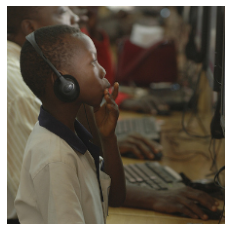

[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'electronic', 'id': 72, 'name': 'tv'}, {'supercategory': 'electronic', 'id': 74, 'name': 'mouse'}, {'supercategory': 'electronic', 'id': 76, 'name': 'keyboard'}]


In [10]:
## Verificação visual do dataset (imagem e categorias = targets)
inv_trans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),
                               ])
img, cats = dummy_dataset[4]
cats = torch.nonzero(cats).squeeze().numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()
print(coco_inst_train.loadCats(cats))

# Carregamento do Dataset

In [11]:
##Número de exemplos do dataset
all_img_ids_train = coco_inst_train.getImgIds()
all_img_ids_val_test = coco_inst_val.getImgIds()

data_train_ex_num = len(all_img_ids_train)
data_valid_ex_num = int(len(all_img_ids_val_test) / 2) #validation coco dataset was divided in two sets, one being used as val and other as test (test set is not used in validation or training)
data_test_ex_num = int(len(all_img_ids_val_test) / 2)
all_ex_num = data_train_ex_num + data_valid_ex_num + data_test_ex_num

## Número de exemplos (truncado ou não)
train_ex_num = 10000
valid_ex_num = 1000
test_ex_num = 1000

max_lines = train_ex_num + valid_ex_num + test_ex_num

print(f"Number of examples used: {max_lines}; Number of examples in the dataset: {all_ex_num}")

## Carregamento do Dataset

img_ids_train = all_img_ids_train[:train_ex_num]
img_ids_val = all_img_ids_val_test[:valid_ex_num]
img_ids_test = all_img_ids_val_test[valid_ex_num:valid_ex_num + test_ex_num]

print(f"Train: {len(img_ids_train)}, Valid: {len(img_ids_val)}, Test: {len(img_ids_test)}")

train_dataset = MyDataset(img_ids=img_ids_train, coco=coco_inst_train, file_dir='train2017', transformations=transformations, num_cats=num_cats)
valid_dataset = MyDataset(img_ids=img_ids_val, coco=coco_inst_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)
test_dataset = MyDataset(img_ids=img_ids_test, coco=coco_inst_val, file_dir='val2017', transformations=transformations, num_cats=num_cats)


Number of examples used: 12000; Number of examples in the dataset: 123287
Train: 10000, Valid: 1000, Test: 1000


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [12]:
class MultiLabelClassifier(nn.Module):

    def __init__(self, num_cats):
        super().__init__()
        self.num_cats = num_cats
        self.resnet34 = models.resnet34(pretrained=True)
        self.model_1_wo_fc = nn.Sequential(*(list(self.resnet34.children())[:-1])).to(device)

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.20),
            nn.Linear(in_features=512, out_features=num_cats),
            nn.Sigmoid()
        ).to(device)
    
    def forward(self, input):
        y_hat = self.model_1_wo_fc(input)
        y_hat = torch.flatten(y_hat, 1)
        y_hat = self.classifier(y_hat)

        return y_hat

#Teste do Modelo

In [13]:
model_1_test = MultiLabelClassifier(num_cats=num_cats)

sample_input, _ = next(iter(DataLoader(train_dataset)))
sample_output = model_1_test(sample_input.to(device))

print(f'sample_input.shape: {sample_input.shape}')
print(f'sample_output.shape: {sample_output.shape}')

num_params = sum(p.numel() for p in model_1_test.parameters() if p.requires_grad)
print(f'Number of model parameters: {num_params}')

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

sample_input.shape: torch.Size([1, 3, 224, 224])
sample_output.shape: torch.Size([1, 91])
Number of model parameters: 21844355


#Laço de treinamento

In [14]:
max_examples = 50_000
eval_every_steps = 1000
lr = 3e-4

model_1 = MultiLabelClassifier(num_cats=num_cats)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
validation_loader = DataLoader(valid_dataset, batch_size=64)

optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

def train_step(inputs, targets):
    model_1.train()
    model_1.zero_grad()
    outputs = model_1(inputs)
    #outputs = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion = nn.BCELoss()
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    return loss.item()


def validation_step(inputs, targets):
    model_1.eval()
    outputs = model_1(inputs)
    #logits = logits.reshape(-1, logits.shape[-1])
    #target_ids = target_ids.reshape(-1)
    criterion = nn.BCELoss()
    loss = criterion(outputs, targets)
    return loss.item()


train_losses = []
n_examples = 0
step = 0
while n_examples < max_examples:
    for train_input, train_target in tqdm.notebook.tqdm(train_loader):
        loss = train_step(train_input.to(device), train_target.to(device)) 
        train_losses.append(loss)
        
        if step % eval_every_steps == 0:
            train_loss = np.average(train_losses)

            with torch.no_grad():
                valid_loss = np.average([
                    validation_step(val_input.to(device), val_target.to(device))
                    for val_input, val_target in validation_loader])

            print(f'{step} steps; {n_examples} examples so far; train loss: {train_loss:.6f}, valid loss: {valid_loss:.6f}')
            train_losses = []

        n_examples += len(train_input)  # Increment of batch size
        step += 1
        if n_examples >= max_examples:
            break

  0%|          | 0/156 [00:00<?, ?it/s]

0 steps; 0 examples so far; train loss: 0.781090, valid loss: 0.723278


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

#Avaliação do módulo 1 (model_1) no dataset de teste

In [15]:
test_loader = DataLoader(test_dataset, batch_size=64)

with torch.no_grad():
    test_loss = np.average([
        validation_step(test_input.to(device), test_target.to(device))
        for test_input, test_target in test_loader
    ])

print(f'test loss: {test_loss}')

test loss: 0.07352121407166123


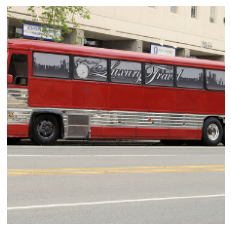

[{'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'}]


array([6])

In [19]:
## Teste com exemplo de teste
index = random.randrange(test_ex_num)
img, cats = test_dataset[index]

## Image categories (random image from the test set)
cats = torch.nonzero(cats).squeeze(1).numpy()
plt.axis('off')
plt.imshow(inv_trans(img).permute(1, 2, 0))
plt.show()
print(coco_inst_val.loadCats(cats))

## Image predicted categories
model_1.eval()
img = img.to(device)
img = img.unsqueeze(0)
cats_predicted = model_1(img)
threshold = 0.7
cats_predicted[cats_predicted >= threshold] = 1
cats_predicted[cats_predicted < threshold] = 0
cats_predicted = cats_predicted.squeeze()
cats_predicted = torch.nonzero(cats_predicted).squeeze(1).cpu().numpy()
cats_predicted